# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree
# import jax; jax.config.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[NbConvertApp] Converting notebook ./src/montecosmo/tests/infer_model.ipynb to script
[NbConvertApp] Writing 8467 bytes to src/montecosmo/tests/infer_model.py


## Config and fiduc

In [2]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
task_id = 3133
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)

SLURM_ARRAY_TASK_ID: 3133


In [3]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir)    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.condition({'obs': truth['obs']})
model.delta_obs = truth['obs'] - 1
model.block()
# model.render()

# CONFIG
{'a_lpt': 0.5,
 'a_obs': 0.5,
 'box_shape': array([320., 320., 320.]),
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'low': 0.05,
                         'scale': 0.2},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'scale': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'scale': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'bs2': {'group': 'bias',
                     'label': '{b}_{s^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'init_mesh': {'group': 'init',
               

2025-01-31 16:23:18.228437: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Analysis

* same volume, more res
* tempering

In [4]:
from montecosmo.mcbench import Chains
task_id = 3133
model, mcmc_config, save_dir, save_path = from_id(task_id)
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
model.delta_obs = truth['obs'] - 1
print(save_path)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield_L362_e4/
/feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield_L362_e4/sMCLMC_nc4_ns64_mt10_ta0.65


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_']) dict_keys(['init_mesh_']) dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_'])


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

MSEs: [4.096876  4.1008015 4.0809455 4.086157 ] [3.6045814 3.6553214 3.68031   3.5548658] [3.6032138 3.5621367 2.261189  2.2591414]


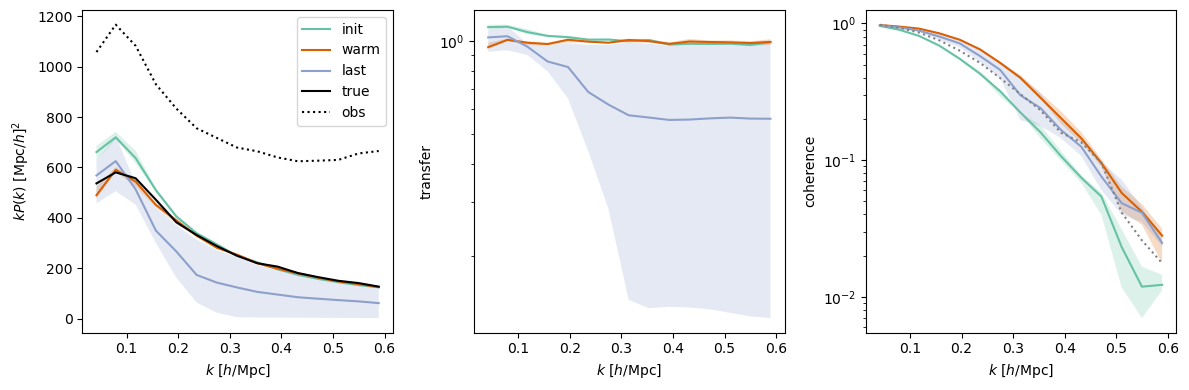

In [5]:
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
theme()
ils = pload(save_path+"_init_last_state.p").z
ls = pload(save_path+"_last_state.p").position # .z, .position
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
init_params_ = jit(vmap(model.init_model))(jr.split(jr.key(43), mcmc_config['n_chains']))
print(init_params_.keys(), ils.keys(), ls.keys())

kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
kptcs = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ls)
kpk0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
kpkobs = model.spectrum(truth['obs']-1)

mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
mse = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ls)['init_mesh']  - mesh0)**2, axis=(1,2,3))
print("MSEs:", mse__, mse_, mse)

prob = 0.95
plt.figure(figsize=(12, 4))
plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
plot_powtranscoh(*kptcs__, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
plot_powtranscoh(*kptcs_, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs), 1), label='last')
plot_powtranscoh(*kptcs, fill=prob)
plt.subplot(131)
plot_pow(*kpk0, 'k', label='true')
plot_pow(*kpkobs, 'k:', label='obs')
plt.legend()
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
plt.tight_layout()
plt.savefig(save_dir+f'initpk_{task_id}.png')

# print("Init mean_acc_prob:", ils.mean_accept_prob, 
#         "\nss:", ils.adapt_state.step_size, 
#         "\nmm_sqrt:", ils.adapt_state.mass_matrix_sqrt)
# print("Last mean_acc_prob:", ls.mean_accept_prob, 
#         "\nss:", ls.adapt_state.step_size, 
#         "\nmm_sqrt:", ls.adapt_state.mass_matrix_sqrt)

In [6]:
from montecosmo.mcbench import Chains, Samples

transforms = [
              lambda x:x[['*~diverging']], 
              partial(Chains.thin, thinning=1), 
              model.reparam_chains, 
              partial(Chains.choice, n=10),
              ]
chains = model.load_runs(save_path, 1, 11, transforms=transforms, batch_ndim=2)
groups = ['cosmo','bias','init']
chains.shape

Loading: sMCLMC_nc4_ns64_mt10_ta0.65, from run 1 to run 11 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obfield_L362_e4/sMCLMC_nc4_ns64_mt10_ta0.65_4.npz does not exist, stopping at run 3


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 192),
 'b1': (4, 192),
 'b2': (4, 192),
 'bn2': (4, 192),
 'bs2': (4, 192),
 'init_mesh': (4, 192, 10),
 'n_evals': (4, 192),
 'sigma8': (4, 192)}


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.24      0.17      0.31      0.05      0.39      3.04      2.52
          b1      1.00      0.55      1.09      0.21      1.50      9.79      1.40
          b2      0.43      0.80      0.08     -0.06      1.13      6.99      1.46
         bn2    -11.48     16.30      0.23    -35.87      2.22      3.08      4.28
         bs2     -0.12      0.88      0.01     -0.77      0.53     14.21      1.11
init_mesh[0]      1.79      1.18      1.35      0.38      3.85      9.68      1.29
init_mesh[1]      0.25      1.02      0.18     -1.04      2.33    199.22      1.01
init_mesh[2]      0.72      1.02      0.52     -0.62      2.65     95.00      1.08
init_mesh[3]     -0.53      1.17     -0.68     -2.20      1.75    140.36      1.04
init_mesh[4]      0.04      1.20     -0.13     -1.78      2.41     85.64      1.06
init_mesh[5]     -0.06      1.15      0.09     -2.19      1.71    201.77      1.01
ini

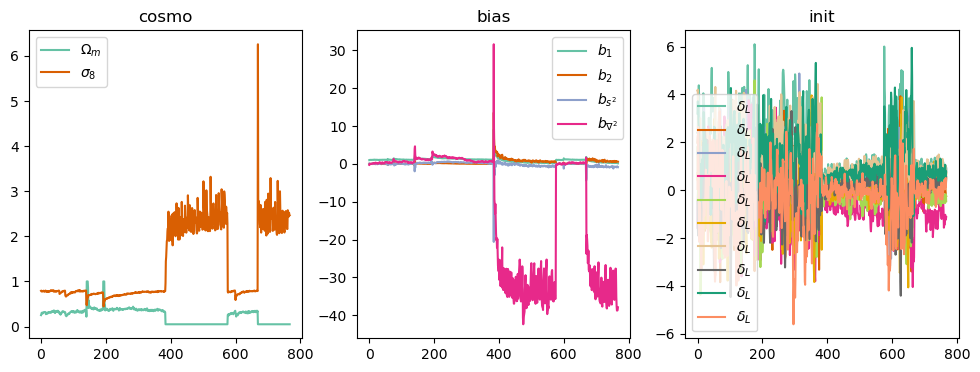

In [7]:
plt.figure(figsize=(12,4))
chains.plot(groups, batch_ndim=2)
chains.print_summary()

Removed no burn in


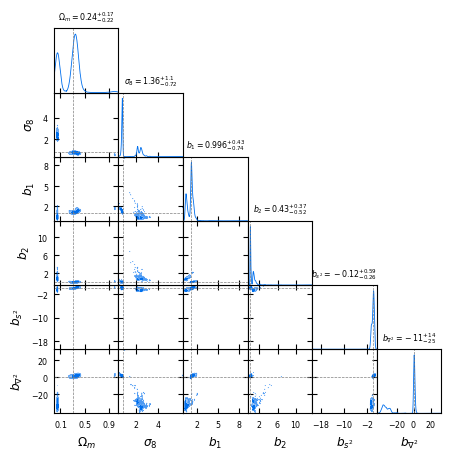

In [8]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

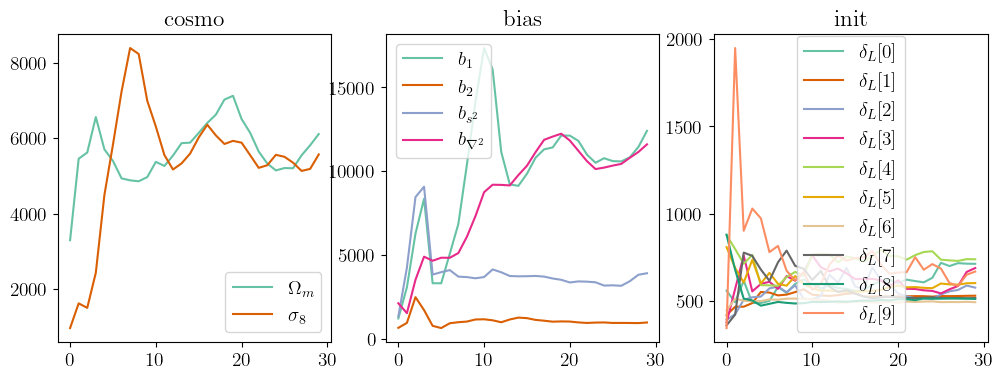

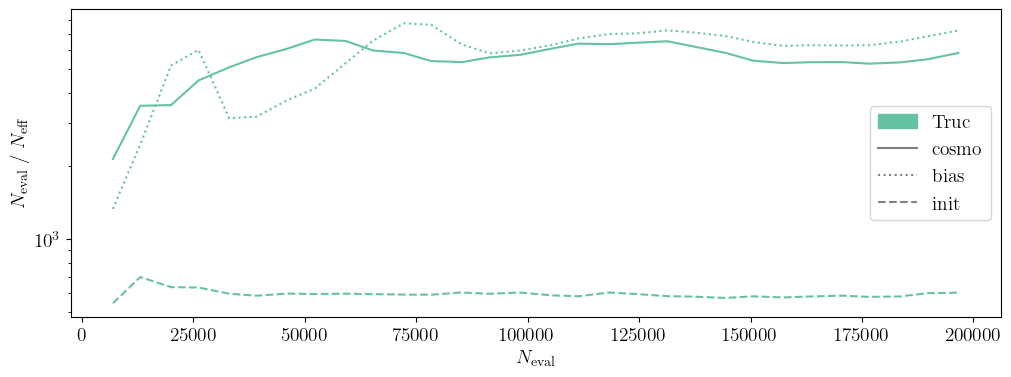

In [18]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(groups, 1)

metrics = []
cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

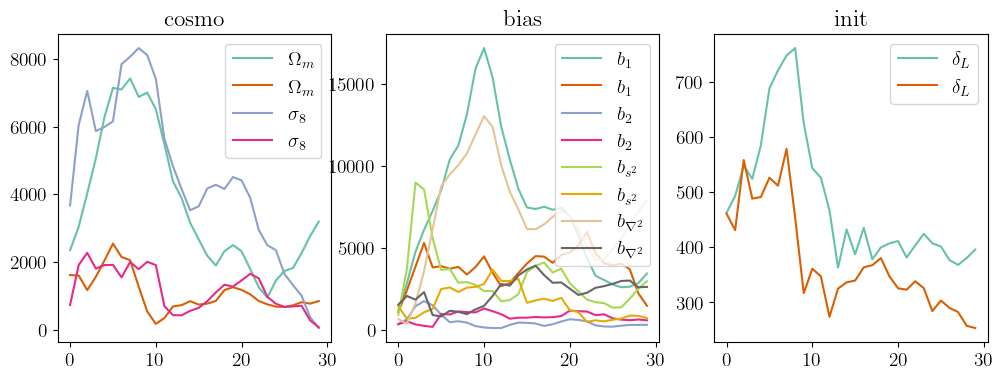

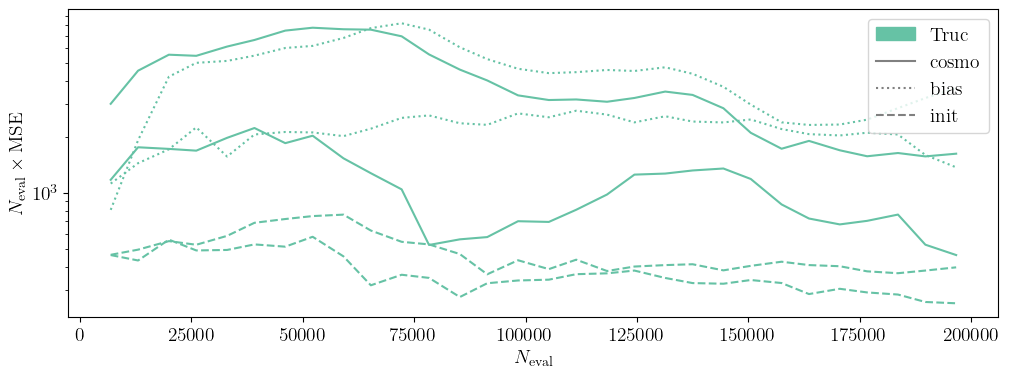

In [19]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)

plt.figure(figsize=(12, 4))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(groups, 1)

metrics = []
true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(groups).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$");

<Figure size 1200x400 with 0 Axes>

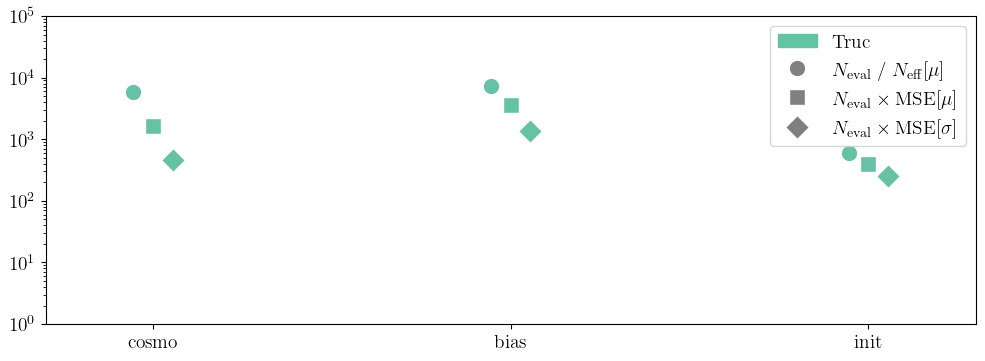

In [20]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))

metrics = []
cumess = chains.stackby(groups).eval_per_ess()
cummse = chains.stackby(groups).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

plt.figure(figsize=(12, 4))
methods = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]

from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
    for i_g, g in enumerate(groups):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, method in enumerate(methods):
    handles.append(Patch(color=SetDark2(i_m), label=method))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right");


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.34      0.02      0.34      0.30      0.38     31.45      1.12
          b1      1.03      0.04      1.04      0.96      1.10     19.75      1.18
          b2     -0.02      0.03     -0.02     -0.08      0.03    103.86      1.04
         bn2      0.34      0.25      0.34     -0.10      0.73     33.74      1.09
         bs2      0.03      0.09      0.02     -0.11      0.19     20.12      1.19
init_mesh[0]      2.29      1.29      2.31      0.11      4.31    401.12      1.01
init_mesh[1]      0.37      1.34      0.38     -1.86      2.55    382.78      1.01
init_mesh[2]      0.73      1.38      0.77     -1.52      3.05    430.04      1.01
init_mesh[3]     -0.33      1.47     -0.32     -2.69      2.13    347.56      1.01
init_mesh[4]      0.20      1.62      0.22     -2.33      2.98    186.94      1.02
init_mesh[5]     -0.19      1.46     -0.18     -2.65      2.08    379.81      1.00
ini

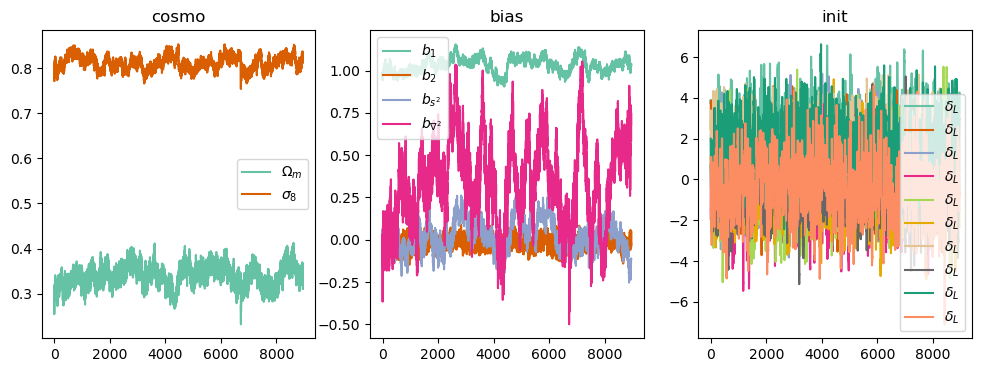

In [ ]:
plt.figure(figsize=(12,4))
chains.plot(groups, batch_ndim=2)
chains.print_summary()

Removed no burn in


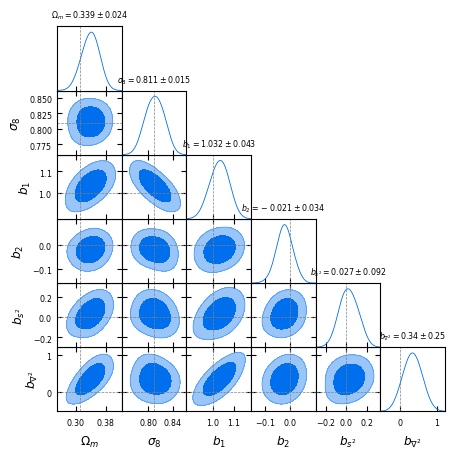

In [41]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

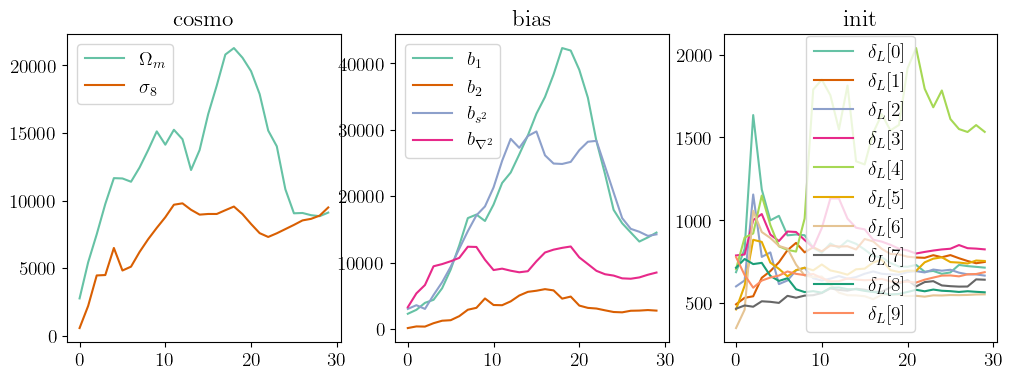

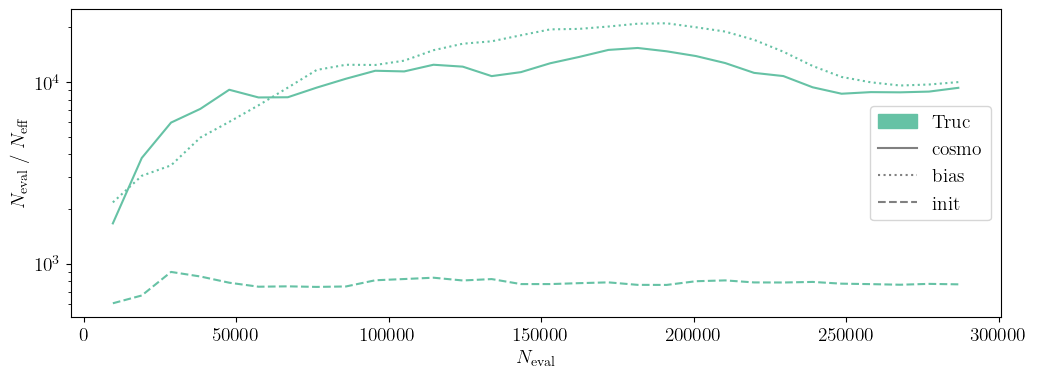

In [53]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(groups, 1)

metrics = []
cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

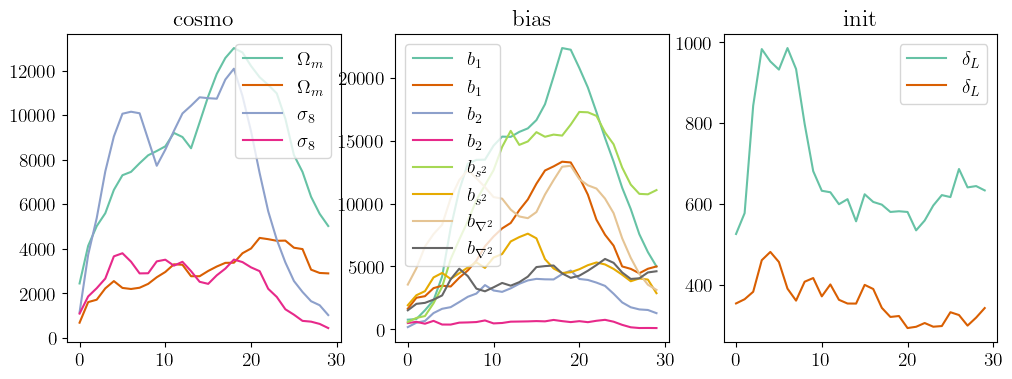

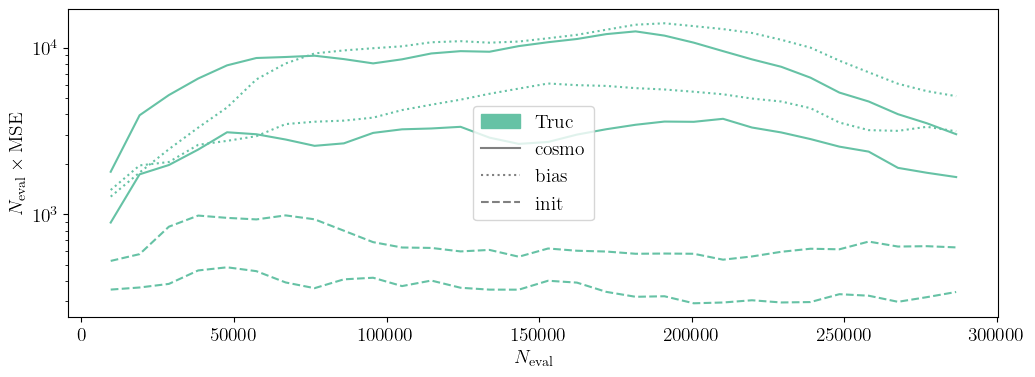

In [54]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)

plt.figure(figsize=(12, 4))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(groups, 1)

metrics = []
true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(groups).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$");

<Figure size 1200x400 with 0 Axes>

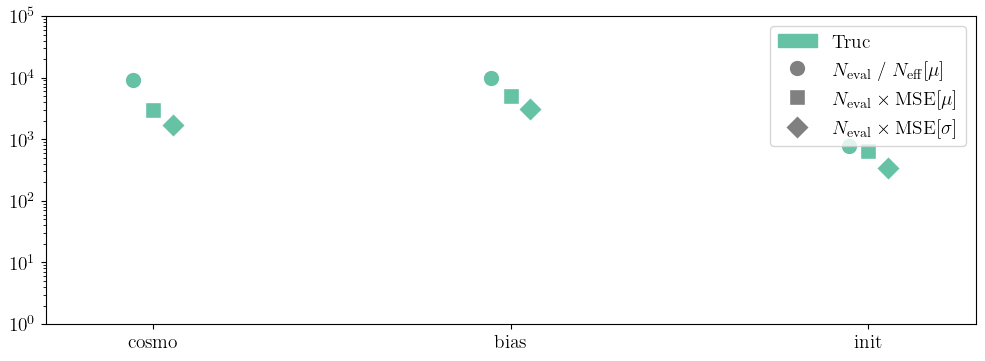

In [55]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))

metrics = []
cumess = chains.stackby(groups).eval_per_ess()
cummse = chains.stackby(groups).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

plt.figure(figsize=(12, 4))
methods = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]

from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
    for i_g, g in enumerate(groups):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, method in enumerate(methods):
    handles.append(Patch(color=SetDark2(i_m), label=method))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right");

## Example


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.31      0.15      0.29      0.10      0.57     64.11      1.01
          b1      1.06      0.52      1.01      0.10      1.85     99.76      1.00
          b2      0.07      2.06      0.17     -3.59      2.94     89.42      1.00
         bn2     -0.30      1.78     -0.11     -3.40      2.19     87.39      1.00
         bs2      0.11      1.68     -0.02     -2.80      2.67    121.15      0.99
init_mesh[0]      0.10      1.70      0.25     -2.29      2.85    126.55      1.00
init_mesh[1]     -0.08      1.54     -0.13     -1.81      3.12    134.99      1.01
init_mesh[2]      0.07      1.59     -0.04     -2.74      2.50    119.47      0.98
init_mesh[3]     -0.11      1.49     -0.04     -2.75      1.88    207.53      1.00
init_mesh[4]     -0.05      1.81     -0.02     -2.85      3.22    127.23      0.99
init_mesh[5]     -0.33      1.46     -0.25     -2.38      2.12    113.33      0.99
ini

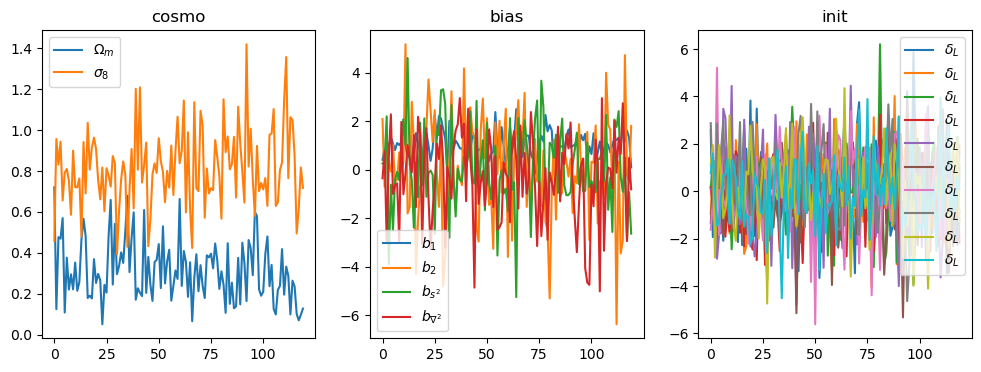

In [ ]:
plt.figure(figsize=(12,4))
chains.plot(groups)
chains.print_summary()

Removed no burn in


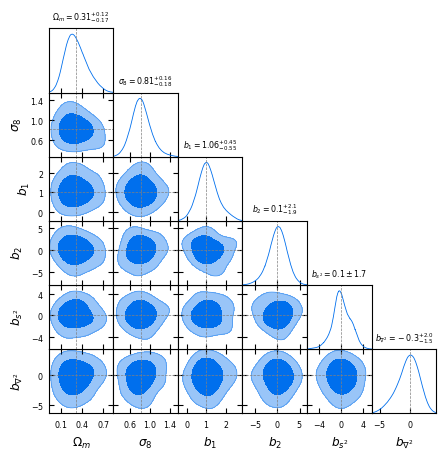

In [ ]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

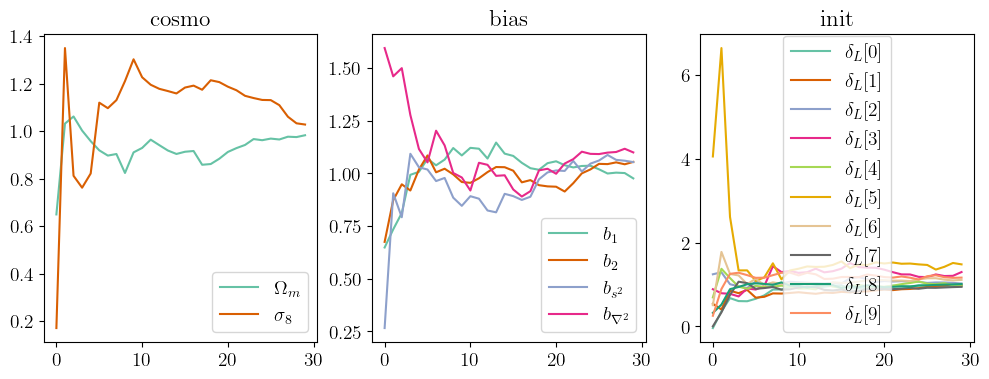

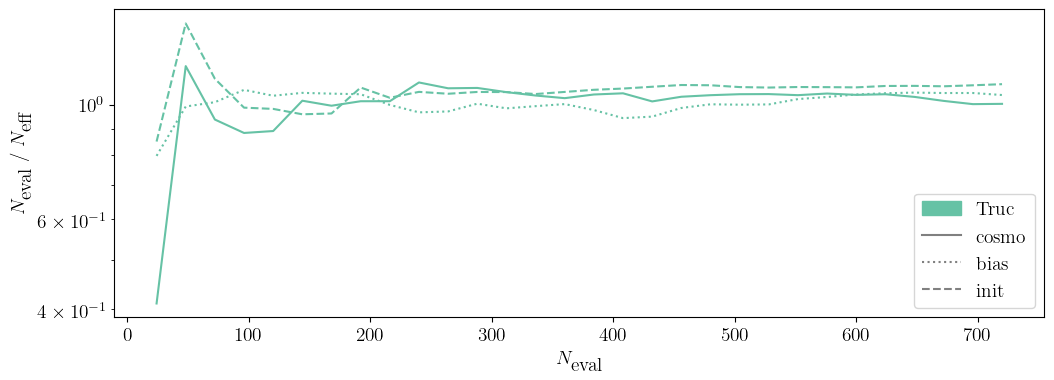

In [60]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(groups, 1)

metrics = []
cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

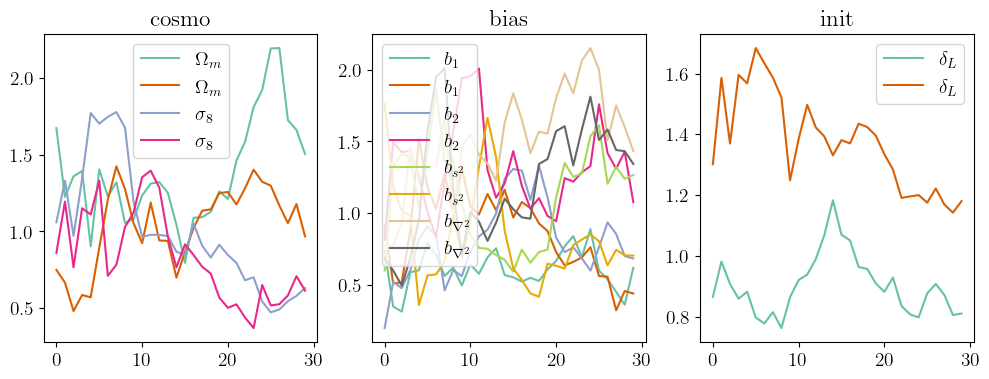

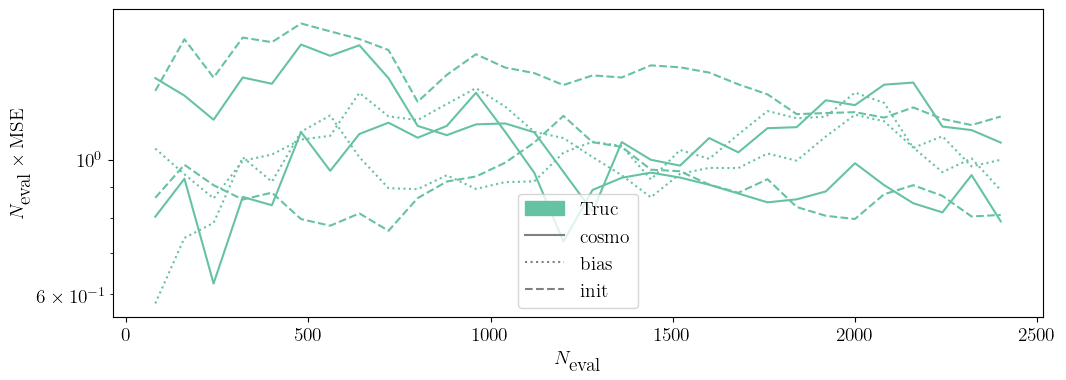

In [97]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)

plt.figure(figsize=(12, 4))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(groups, 1)

metrics = []
true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(groups).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$");

<Figure size 1200x400 with 0 Axes>

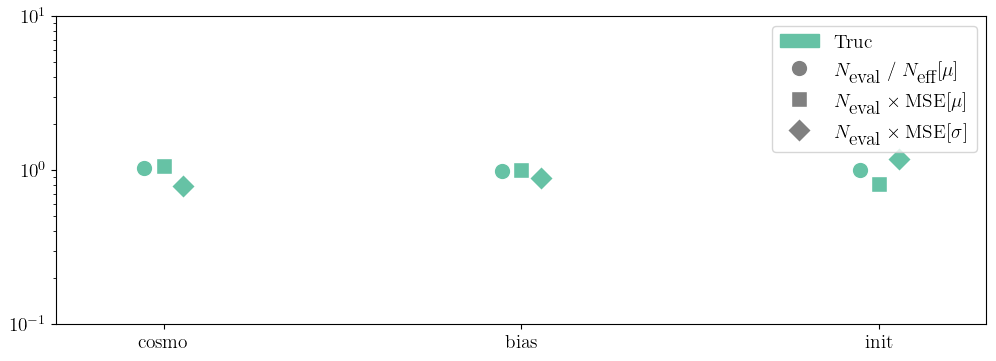

In [98]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))

metrics = []
cumess = chains.stackby(groups).eval_per_ess()
cummse = chains.stackby(groups).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

plt.figure(figsize=(12, 4))
methods = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]
# metric_names = ["ESS", "MSE[$\\mu$]", "MSE[$\\sigma$]"]

from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
    for i_g, g in enumerate(groups):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, method in enumerate(methods):
    handles.append(Patch(color=SetDark2(i_m), label=method))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right");

# Comparison

In [ ]:
from montecosmo.mcbench import Chains
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
groups = ['cosmo','bias','init']

tids = [1130]
labels = 3*['NUTS']

metrics = []
gdsamps = []

for tid, lab in zip(tids, labels):
    model, mcmc_config, save_dir, save_path = from_id(tid)

    # Load truth
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")
    model.delta_obs = truth['obs'] - 1

    # Load chains
    transforms = [
                lambda x: x[['*~diverging']],
                partial(Chains.thin, thinning=1), 
                model.reparam_chains, 
                partial(Chains.choice, n=10)]
    chains = model.load_runs(save_path, 0,10, transforms=transforms, batch_ndim=2)
    print(chains.shape)

    # Load last state
    last_state = pload(save_path + "_last_state.p")
    # print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)

    # Plot chains
    plt.figure(figsize=(12,4))
    chains.plot(['cosmo', 'bias','init'])
    plt.tight_layout()
    plt.savefig(save_dir+f'chains_{tid}.png')
    chains.print_summary()

    # Compute metrics
    cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
    metrics.append(cumess)

    # Prepare KDE
    gdsamp = chains[['cosmo','bias']].to_getdist(lab)
    gdsamps.append(gdsamp)



# Plot KDE
gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=gdsamps,
                title_limit=1,
                filled=True, 
                markers=truth,)
plt.savefig(save_dir+'triangle.png')


# Plot metrics
def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$")
plt.tight_layout()
plt.savefig(save_dir+'cumess.png')
raise

In [56]:
shape = (4,60)
jfn = jit(partial(model.predict, samples=shape))
params = jfn(jr.key(42))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_0", **params)
params = jfn(jr.key(43))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_1", **params)
params = jfn(jr.key(44))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_2", **params)
save_path = save_dir+"samples"